In [274]:
import pandas as pd
import numpy as np
from collections import OrderedDict,defaultdict

from bokeh.plotting import figure,show
from bokeh.layouts import row,column,layout
from ipywidgets import interact 
from bokeh.io import curdoc,curstate
from bokeh.layouts import widgetbox

import warnings
warnings.filterwarnings("ignore")

from bokeh.models.formatters import CategoricalTickFormatter,NumeralTickFormatter
from bokeh.models import (
    HoverTool,
    LinearColorMapper,
    PrintfTickFormatter,
    ColumnDataSource,
    Slider
)
import bokeh.palettes as pt
import time
from bokeh.models.transforms import LinearInterpolator
from  bokeh.models.mappers import CategoricalColorMapper

from bokeh.events import Tap,ButtonClick
from bokeh.models import Button
from bokeh.models.widgets import Div,Paragraph
from bokeh.client import push_session

import re
#datashader --yay!
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf
from collections import OrderedDict
import xarray as xr
from datashader import reductions
from datashader.bokeh_ext import InteractiveImage


In [7]:
from bokeh.io import output_notebook, push_notebook
output_notebook()

Loading BokehJS ...

In [ ]:
reviews=pd.read_csv('./Reviews.csv')
reviews.head()

In [101]:
aliases=[]
names=[]

def prune_names(profilenames):
    for name in profilenames:
        if(type(name) == float):
            names.append("No name")
            aliases.append("No alias")
            continue
            
        if("\"" in name):
            first=name.split("\"")
            first[0]=re.sub(r'[^A-Za-z0-9.\s]','',first[0])
            first[1]=re.sub(r'[^A-Za-z0-9.\s]','',first[1])
             
            names.append(first[0])
            aliases.append(first[1])
        else:
            names.append(name)
            aliases.append("No alias")

users=reviews[['ProfileName','UserId']]
profilenames=users['ProfileName'].tolist()
usernames=users['UserId'].tolist()

prune_names(profilenames)

l=list(zip(names,aliases,usernames))
s=pd.Series(data=l)
svc=s.value_counts()

In [ ]:
name_alias_ids=svc.keys().tolist()
num_reviews=svc.values.tolist()

unzipped=list(zip(*name_alias_ids))
names=unzipped[0]
aliases=unzipped[1]
ids=unzipped[2]
indices=list(range(len(ids)))

users_df=pd.DataFrame(data=dict(index=indices,names=names,aliases=aliases,ids=ids,nreviews=num_reviews))

In [142]:
PLOT_OPTS=dict(height=400,width=600,toolbar_location="above")
TOOLS = "save,pan,box_select,reset,hover"

source=ColumnDataSource(data=users_df)
bplot=figure(**PLOT_OPTS,tools=TOOLS,y_range=(0,20))
bplot.vbar(x='index',top='nreviews',bottom=0,width=0.5,source=source,legend='USerReviews') 
    
bplot.legend.orientation = "horizontal"
bplot.legend.location = "top_center"
bplot.xaxis.major_label_orientation = np.pi/2

handle=show(bplot,notebook_handle=True)

Wall time: 62.5 ms


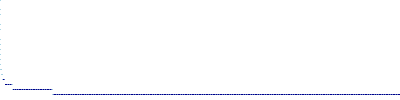

In [174]:
%time tf.shade(ds.Canvas(plot_height=100,plot_width=400,y_range=(0,20)).points(users_df,'index','nreviews',\
                                                                              agg=reductions.count()))
#default colormap is from dark blue to light blue.
#each bin is mapped to one pixel - RGB value.
#opacity of each pixel 1/0 if non-empty/empty.

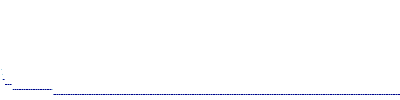

In [164]:
canvas=ds.Canvas(plot_height=100,plot_width=400,y_range=(0,20))
agg=canvas.points(users_df,'index','nreviews',agg=reductions.count())
tf.shade(agg.where(agg>=np.percentile(agg,99)))                

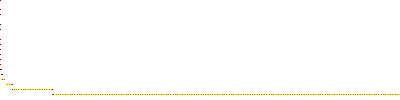

In [175]:
tf.shade(agg,cmap=['darkred','yellow'])
#yellow indicates more number of points in that bin/pixel.
#darkred shows less number of points in that bin/pixel
#All the other values linear interpolation between highest and lowest.

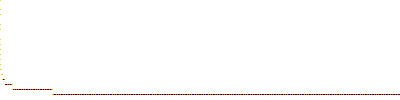

In [177]:
tf.shade(agg,cmap=[(230,230,0), "orangered", "#300030"]) #yellow, orangered,purple.

Wall time: 0 ns


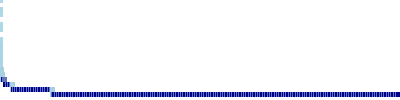

In [195]:
img=tf.shade(agg)
tf.set_background(img,'blue')
%time tf.spread(img,px=2,shape='square')

In [222]:
import bokeh.plotting as bp
p = bp.figure(tools='pan,wheel_zoom,reset,box_select,hover', x_range=(0,len(users_df)),y_range=(0,40),plot_width=400,plot_height=200)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = canvas.points(users_df,'index','nreviews',agg=reductions.count())
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.80)

InteractiveImage(p, image_callback)

In [224]:
print(ids[:10])

('AY12DBB0U420B', 'A1Z54EM24Y40LL', 'A3OXHLG6DIBRW8', 'A2SZLNSI5KOQJT', 'A1YUL9PCJR3JTY', 'A3PJZ8TU8FDQ1K', 'A31N6KB160O508', 'A1TMAVN4CEM8U8', 'A281NPSIMI1C2R', 'A3HPCRD9RX351S')


In [277]:

gary_reviews=reviews[reviews['UserId']=='AY12DBB0U420B']
print(len(gary_reviews))
summaries=gary_reviews[['ProductId','Summary','Text','Score']]
text=summaries['Text']
#Find out named entities which are a set of consecutive capitalized words in the description of an item. 
#Remove teh non-alphanumeric characters first.

stopwords=['i\'ve','i\'m','i\'d','i\'ll']
named_entities=defaultdict(int)
for i in text:
    i=re.sub(r'<br>|<br />',' ',i)
    i=re.sub(r'[^A-Za-z0-9.!\'\s]','',i)
    #print(i)
    tokens=i.split()
    ne=''
    for tok in tokens:
        if(tok.lower() in stopwords or len(tok)<2):
            continue
        if(tok[0].isupper()):
            ne=ne+" "+tok
            #print(ne,len(ne.split())) 
            if(tok[-1]=='.'):
                if(len(ne.split())>1):
                    named_entities[ne[:-1]]+=1
                ne=''   
        elif(len(ne.split())>1):
            named_entities[ne]+=1
            ne=''  
        else: 
            ne=""
    if(len(ne.split())>1):
        named_entities[ne]+=1
        ne=''  
        
print(named_entities.keys(),named_entities.values())     

30
dict_keys([' Easy Neighborhood Grocery', ' Tillen Farms Pickled Crispy Asparagus', ' This Tillen Farms', ' Gary Peterson', ' Easy Neighborhood Market', ' Butternut Squash', ' Red Pepper Soup', ' Sea White Tuna Cups', ' Enjoy Life Boom Choco Boom Dark Chocolate Bar', ' Yum! In', ' Panda Soft Licorice', ' The Panda', ' Easy Market', ' James Keiller Son Dundee Ginger Preserve', ' Wild Planet', ' Extra Virgin', ' Mae Ploy', " Werther's Original Hard Candies Sugar Free", " Trader Joe's", ' Kirkland Signature', ' Kirkland Signature Rwandan Whole Bean Dark Roast Coffee', ' The Aroma', ' Wonderful! And', " Robinson's Apple", ' Blackcurrant Fruit Drink', ' Delicious! Very', ' Crystal Geyser', ' Orville Redenbacher Microwave Popcorn', " Orville Redenbacher's Smart Pop", ' Lake Murray', ' Nongshim Bowl Noodle Soup', ' Spicy Chicken', ' Delicious Apple', ' Heinz Spotted Dick Pudding', ' When It', ' Columbian Supremo', ' Trader Joes', ' Starbucks French Roast', ' Kirkland Signature House Blend',